In [ ]:
# Flight Delay Prediction Full Notebook with Optuna Tuning and Pipelines

# === Imports and Data Loading ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import lime
import lime.lime_tabular

import optuna

In [ ]:
# === Load Dataset ===
df_flights = pd.read_csv('/kaggle/input/flight-delay-csv/full_data_flightdelay.csv')

In [ ]:
# === Data Preprocessing ===
df_fe = df_flights.copy()
df_fe.duplicated().sum()

28473

In [ ]:
df_fe = df_fe.drop_duplicates()

# =====Downsampling=====

In [ ]:
# Downsampling to balance classes
df_fe = df_fe.sample(frac=0.3, random_state=42)
df_class_0 = df_fe[df_fe['DEP_DEL15'] == 0]
df_class_1 = df_fe[df_fe['DEP_DEL15'] == 1]
df_class_0_downsampled = df_class_0.sample(n=len(df_class_1), random_state=42)
df_ds_balanced = pd.concat([df_class_0_downsampled, df_class_1], axis=0)
df_ds_balanced = df_ds_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class distribution after downsampling:")
print(df_ds_balanced['DEP_DEL15'].value_counts())


Class distribution after downsampling:
DEP_DEL15
0    368002
1    368002
Name: count, dtype: int64


## Downsampling is done to improve target class imbalance

# ==Encoding Departing and previous airport columns==

In [ ]:
airport_counts = pd.concat([df_ds_balanced['DEPARTING_AIRPORT'], df_ds_balanced['PREVIOUS_AIRPORT']]).value_counts()
df_ds_balanced['DEPARTING_AIRPORT'] = df_ds_balanced['DEPARTING_AIRPORT'].map(airport_counts)
df_ds_balanced['PREVIOUS_AIRPORT'] = df_ds_balanced['PREVIOUS_AIRPORT'].map(airport_counts)
df_ds_balanced.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,11,5,0,0700-0759,5,1,13,76,SkyWest Airlines Inc.,3240,...,4,8363,29.533,-98.469,140506,0.01,0.0,0.0,71.0,9.17
1,12,1,1,1800-1859,6,4,55,173,United Air Lines Inc.,15165,...,6,31018,29.983,-95.340,29287,0.03,0.0,0.0,82.0,11.18
2,12,7,1,2000-2059,1,6,67,76,"Midwest Airline, Inc.",13603,...,11,28384,42.217,-83.344,10140,0.95,0.0,0.0,50.0,4.92
3,8,7,0,1500-1559,3,4,78,76,Endeavor Air Inc.,35256,...,11,65493,33.641,-84.427,427,0.00,0.0,0.0,96.0,6.04
4,12,2,0,1600-1659,3,4,49,160,American Airlines Inc.,19683,...,6,41231,35.219,-80.936,2656,0.66,0.0,0.0,63.0,11.18


## The two columns were object type, performed frequency based imputation to make them numeric type features

# ===Encoding Carrier Name column===

In [ ]:
categorical_columns = ['CARRIER_NAME']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(df_ds_balanced[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=df_ds_balanced.index)
df_encoded = pd.concat([df_ds_balanced.drop(categorical_columns, axis=1), one_hot_df], axis=1)
df_encoded.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,CARRIER_NAME_Endeavor Air Inc.,CARRIER_NAME_Frontier Airlines Inc.,CARRIER_NAME_Hawaiian Airlines Inc.,CARRIER_NAME_JetBlue Airways,CARRIER_NAME_Mesa Airlines Inc.,"CARRIER_NAME_Midwest Airline, Inc.",CARRIER_NAME_SkyWest Airlines Inc.,CARRIER_NAME_Southwest Airlines Co.,CARRIER_NAME_Spirit Air Lines,CARRIER_NAME_United Air Lines Inc.
0,11,5,0,0700-0759,5,1,13,76,3240,66502,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,12,1,1,1800-1859,6,4,55,173,15165,51152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,12,7,1,2000-2059,1,6,67,76,13603,28319,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,7,0,1500-1559,3,4,78,76,35256,22671,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,2,0,1600-1659,3,4,49,160,19683,79228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## The feature was object type, performing sklearn's onehot encoding to convert it to numeric feature.

# ====Encoding time block====

In [ ]:
df_encoded['DEP_TIME_BLK'] = df_encoded['DEP_TIME_BLK'].str.strip()
df_encoded[['DEP_TIME_START', 'DEP_TIME_END']] = df_encoded['DEP_TIME_BLK'].str.split('-', expand=True)
df_encoded['DEP_TIME_START'] = pd.to_datetime(df_encoded['DEP_TIME_START'], format='%H%M')
df_encoded = df_encoded.drop(['DEP_TIME_BLK', 'DEP_TIME_END'], axis=1)
df_encoded.sample(5)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,...,CARRIER_NAME_Frontier Airlines Inc.,CARRIER_NAME_Hawaiian Airlines Inc.,CARRIER_NAME_JetBlue Airways,CARRIER_NAME_Mesa Airlines Inc.,"CARRIER_NAME_Midwest Airline, Inc.",CARRIER_NAME_SkyWest Airlines Inc.,CARRIER_NAME_Southwest Airlines Co.,CARRIER_NAME_Spirit Air Lines,CARRIER_NAME_United Air Lines Inc.,DEP_TIME_START
229493,5,5,1,1,2,6,181,3353,78894,706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 16:00:00
143097,8,5,1,6,1,11,181,2187,24460,1542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:01:00
584683,7,3,0,2,5,10,143,7162,117728,3593,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1900-01-01 15:00:00
386268,6,4,1,5,1,19,230,4282,11337,310,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 07:00:00
385914,4,7,0,1,2,65,90,18979,23434,7448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 09:00:00


# ====Working with date time====

In [ ]:
from datetime import datetime

df_encoded['DEP_TIME_START'] = df_encoded['DEP_TIME_START'].dt.strftime('%H:%M:%S')

df_encoded['DEP_TIME_START'] = df_encoded['DEP_TIME_START'].apply(
    lambda x: datetime.strptime(x, '%H:%M:%S').time()
)

df_encoded['DEP_HOUR'] = df_encoded['DEP_TIME_START'].apply(lambda x: x.hour)
df_encoded = df_encoded.drop('DEP_TIME_START', axis=1)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736004 entries, 0 to 736003
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   MONTH                                      736004 non-null  int64  
 1   DAY_OF_WEEK                                736004 non-null  int64  
 2   DEP_DEL15                                  736004 non-null  int64  
 3   DISTANCE_GROUP                             736004 non-null  int64  
 4   SEGMENT_NUMBER                             736004 non-null  int64  
 5   CONCURRENT_FLIGHTS                         736004 non-null  int64  
 6   NUMBER_OF_SEATS                            736004 non-null  int64  
 7   AIRPORT_FLIGHTS_MONTH                      736004 non-null  int64  
 8   AIRLINE_FLIGHTS_MONTH                      736004 non-null  int64  
 9   AIRLINE_AIRPORT_FLIGHTS_MONTH              736004 non-null  int64  
 10  AVG_MONT

In [ ]:
df_encoded.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,...,CARRIER_NAME_Frontier Airlines Inc.,CARRIER_NAME_Hawaiian Airlines Inc.,CARRIER_NAME_JetBlue Airways,CARRIER_NAME_Mesa Airlines Inc.,"CARRIER_NAME_Midwest Airline, Inc.",CARRIER_NAME_SkyWest Airlines Inc.,CARRIER_NAME_Southwest Airlines Co.,CARRIER_NAME_Spirit Air Lines,CARRIER_NAME_United Air Lines Inc.,DEP_HOUR
0,11,5,0,5,1,13,76,3240,66502,302,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
1,12,1,1,6,4,55,173,15165,51152,5162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18
2,12,7,1,1,6,67,76,13603,28319,684,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20
3,8,7,0,3,4,78,76,35256,22671,3847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,12,2,0,3,4,49,160,19683,79228,8434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16


## The feature DEP_TIME_BLK was converted from object type to integer type.

# Hyperparameter tuning is done by using OPTUNA
# XGBoost, Logistic Regression and CATBoost algorithms are used

# ====XGBoost OPTUNA====

In [ ]:
# Features and labels
X = df_encoded.drop('DEP_DEL15', axis=1)
y = df_encoded['DEP_DEL15']

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 900, 2200)
    learning_rate = trial.suggest_float("learning_rate", 0.08, 0.2, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 10)

    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Lists to collect training and testing metrics
    train_acc_list, train_prec_list, train_rec_list, train_f1_list, train_roc_auc_list = [], [], [], [], []
    test_acc_list, test_prec_list, test_rec_list, test_f1_list, test_roc_auc_list = [], [], [], [], []

    # K-Fold loop
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")

        # Split into train and test for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train model with trial-suggested params
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train)

        # Predict on test set
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Predict on training set
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]

        # Test set metrics
        test_acc_list.append(accuracy_score(y_test, y_test_pred))
        test_prec_list.append(precision_score(y_test, y_test_pred))
        test_rec_list.append(recall_score(y_test, y_test_pred))
        test_f1_list.append(f1_score(y_test, y_test_pred))
        test_roc_auc_list.append(roc_auc_score(y_test, y_test_proba))

        # Training set metrics
        train_acc_list.append(accuracy_score(y_train, y_train_pred))
        train_prec_list.append(precision_score(y_train, y_train_pred))
        train_rec_list.append(recall_score(y_train, y_train_pred))
        train_f1_list.append(f1_score(y_train, y_train_pred))
        train_roc_auc_list.append(roc_auc_score(y_train, y_train_proba))

        print(classification_report(y_test, y_test_pred))

    # Print Average Training Metrics
    print("\n=== Average Training Metrics Across 4 Folds ===")
    print(f"Accuracy:  {np.mean(train_acc_list):.4f}")
    print(f"Precision: {np.mean(train_prec_list):.4f}")
    print(f"Recall:    {np.mean(train_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(train_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(train_roc_auc_list):.4f}")

    # Print Average Testing Metrics
    print("\n=== Average Testing Metrics Across 4 Folds ===")
    print(f"Accuracy:  {np.mean(test_acc_list):.4f}")
    print(f"Precision: {np.mean(test_prec_list):.4f}")
    print(f"Recall:    {np.mean(test_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(test_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(test_roc_auc_list):.4f}")

    # Return validation (test) F1 score for Optuna to optimize
    return np.mean(test_f1_list)

# Run the study
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective, n_trials=10)

print("\nBest trial:")
print(study_xgb.best_trial)


# Extract best parameters
best_params_xgb = {
    "n_estimators": study_xgb.best_trial.params["n_estimators"],
    "learning_rate": study_xgb.best_trial.params["learning_rate"],
    "max_depth": study_xgb.best_trial.params["max_depth"],
    "random_state": 42,
    "use_label_encoder": False,
    "eval_metric": "logloss"
}

[I 2025-08-10 16:59:23,164] A new study created in memory with name: no-name-153435d6-d8c1-48fb-ba0f-cbdcf88f87ca



Fold 1
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14734
           1       0.64      0.63      0.63     14707

    accuracy                           0.63     29441
   macro avg       0.63      0.63      0.63     29441
weighted avg       0.63      0.63      0.63     29441


Fold 2
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14733
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29440


Fold 3
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     14733
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29

[I 2025-08-10 17:00:51,667] Trial 0 finished with value: 0.6318654305078287 and parameters: {'n_estimators': 1623, 'learning_rate': 0.14356408331689646, 'max_depth': 8}. Best is trial 0 with value: 0.6318654305078287.


              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14733
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9969
Precision: 0.9972
Recall:    0.9966
F1 Score:  0.9969
ROC AUC:   1.0000

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6336
Precision: 0.6343
Recall:    0.6294
F1 Score:  0.6319
ROC AUC:   0.6854

Fold 1
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14734
           1       0.65      0.64      0.65     14707

    accuracy                           0.65     29441
   macro avg       0.65      0.65      0.65     29441
weighted avg       0.65      0.65      0.65     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:01:27,410] Trial 1 finished with value: 0.6456193558960528 and parameters: {'n_estimators': 1160, 'learning_rate': 0.09846637025560163, 'max_depth': 5}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14733
           1       0.65      0.64      0.65     14707

    accuracy                           0.65     29440
   macro avg       0.65      0.65      0.65     29440
weighted avg       0.65      0.65      0.65     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.7658
Precision: 0.7714
Recall:    0.7548
F1 Score:  0.7630
ROC AUC:   0.8501

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6492
Precision: 0.6517
Recall:    0.6397
F1 Score:  0.6456
ROC AUC:   0.7067

Fold 1
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14734
           1       0.64      0.63      0.63     14707

    accuracy                           0.64     29441
   macro avg       0.64      0.64      0.64     29441
weighted avg       0.64      0.64      0.64     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:02:22,650] Trial 2 finished with value: 0.6323273693082984 and parameters: {'n_estimators': 1287, 'learning_rate': 0.17863358608274457, 'max_depth': 7}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.63      0.63     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9703
Precision: 0.9735
Recall:    0.9669
F1 Score:  0.9702
ROC AUC:   0.9963

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6347
Precision: 0.6358
Recall:    0.6289
F1 Score:  0.6323
ROC AUC:   0.6868

Fold 1
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14734
           1       0.64      0.63      0.64     14707

    accuracy                           0.64     29441
   macro avg       0.64      0.64      0.64     29441
weighted avg       0.64      0.64      0.64     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:04:58,101] Trial 3 finished with value: 0.6328959959204545 and parameters: {'n_estimators': 1921, 'learning_rate': 0.08691023764653018, 'max_depth': 10}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14733
           1       0.64      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9999
Precision: 0.9999
Recall:    1.0000
F1 Score:  0.9999
ROC AUC:   1.0000

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6351
Precision: 0.6361
Recall:    0.6297
F1 Score:  0.6329
ROC AUC:   0.6898

Fold 1
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     14734
           1       0.65      0.64      0.64     14707

    accuracy                           0.65     29441
   macro avg       0.65      0.65      0.65     29441
weighted avg       0.65      0.65      0.65     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:05:39,301] Trial 4 finished with value: 0.6395313520724311 and parameters: {'n_estimators': 1336, 'learning_rate': 0.16873592900266648, 'max_depth': 5}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.64      0.65      0.64     14733
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.8235
Precision: 0.8300
Recall:    0.8132
F1 Score:  0.8215
ROC AUC:   0.9085

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6424
Precision: 0.6442
Recall:    0.6350
F1 Score:  0.6395
ROC AUC:   0.6983

Fold 1
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     14734
           1       0.64      0.63      0.64     14707

    accuracy                           0.64     29441
   macro avg       0.64      0.64      0.64     29441
weighted avg       0.64      0.64      0.64     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:06:42,278] Trial 5 finished with value: 0.6353090146351437 and parameters: {'n_estimators': 2126, 'learning_rate': 0.18978303751249823, 'max_depth': 5}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.8850
Precision: 0.8901
Recall:    0.8782
F1 Score:  0.8841
ROC AUC:   0.9568

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6380
Precision: 0.6395
Recall:    0.6312
F1 Score:  0.6353
ROC AUC:   0.6908

Fold 1
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     14734
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29441
   macro avg       0.63      0.63      0.63     29441
weighted avg       0.63      0.63      0.63     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:08:31,918] Trial 6 finished with value: 0.6338806589885956 and parameters: {'n_estimators': 1338, 'learning_rate': 0.10615110223038735, 'max_depth': 10}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.63      0.63     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9998
Precision: 0.9998
Recall:    0.9998
F1 Score:  0.9998
ROC AUC:   1.0000

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6355
Precision: 0.6362
Recall:    0.6316
F1 Score:  0.6339
ROC AUC:   0.6892

Fold 1
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     14734
           1       0.64      0.63      0.64     14707

    accuracy                           0.64     29441
   macro avg       0.64      0.64      0.64     29441
weighted avg       0.64      0.64      0.64     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:10:00,643] Trial 7 finished with value: 0.6342432446125411 and parameters: {'n_estimators': 1701, 'learning_rate': 0.10695706308431305, 'max_depth': 8}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.63      0.64      0.63     14733
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9880
Precision: 0.9899
Recall:    0.9861
F1 Score:  0.9880
ROC AUC:   0.9993

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6366
Precision: 0.6378
Recall:    0.6308
F1 Score:  0.6342
ROC AUC:   0.6898

Fold 1
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     14734
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29441
   macro avg       0.64      0.64      0.64     29441
weighted avg       0.64      0.64      0.64     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:11:11,488] Trial 8 finished with value: 0.6367056124822861 and parameters: {'n_estimators': 1591, 'learning_rate': 0.10586384988697504, 'max_depth': 7}. Best is trial 1 with value: 0.6456193558960528.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.63      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9390
Precision: 0.9442
Recall:    0.9330
F1 Score:  0.9386
ROC AUC:   0.9862

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6392
Precision: 0.6405
Recall:    0.6329
F1 Score:  0.6367
ROC AUC:   0.6931

Fold 1
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14734
           1       0.65      0.64      0.65     14707

    accuracy                           0.65     29441
   macro avg       0.65      0.65      0.65     29441
weighted avg       0.65      0.65      0.65     29441


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 17:11:55,618] Trial 9 finished with value: 0.6489245811290547 and parameters: {'n_estimators': 2118, 'learning_rate': 0.08022713081984408, 'max_depth': 3}. Best is trial 9 with value: 0.6489245811290547.


              precision    recall  f1-score   support

           0       0.65      0.65      0.65     14733
           1       0.65      0.65      0.65     14707

    accuracy                           0.65     29440
   macro avg       0.65      0.65      0.65     29440
weighted avg       0.65      0.65      0.65     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.6914
Precision: 0.6935
Recall:    0.6849
F1 Score:  0.6892
ROC AUC:   0.7632

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6507
Precision: 0.6516
Recall:    0.6463
F1 Score:  0.6489
ROC AUC:   0.7093

Best trial:
FrozenTrial(number=9, state=1, values=[0.6489245811290547], datetime_start=datetime.datetime(2025, 8, 10, 17, 11, 11, 489637), datetime_complete=datetime.datetime(2025, 8, 10, 17, 11, 55, 618221), params={'n_estimators': 2118, 'learning_rate': 0.08022713081984408, 'max_depth': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistributio

# =====LR OPTUNA=====

In [ ]:
# Features and labels
df_encoded = df_encoded.sample(frac=0.4, random_state=42)

X = df_encoded.drop('DEP_DEL15', axis=1)
y = df_encoded['DEP_DEL15']

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-4, 100.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Lists for metrics
    train_acc_list, train_prec_list, train_rec_list, train_f1_list, train_roc_auc_list = [], [], [], [], []
    test_acc_list, test_prec_list, test_rec_list, test_f1_list, test_roc_auc_list = [], [], [], [], []

    # CV loop
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply scaling within the fold to avoid data leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)


        # Model
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            random_state=42,
            max_iter=200
        )
        model.fit(X_train, y_train)

        # Predictions
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]

        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]

        # Test metrics
        test_acc_list.append(accuracy_score(y_test, y_test_pred))
        test_prec_list.append(precision_score(y_test, y_test_pred))
        test_rec_list.append(recall_score(y_test, y_test_pred))
        test_f1_list.append(f1_score(y_test, y_test_pred))
        test_roc_auc_list.append(roc_auc_score(y_test, y_test_proba))

        # Train metrics
        train_acc_list.append(accuracy_score(y_train, y_train_pred))
        train_prec_list.append(precision_score(y_train, y_train_pred))
        train_rec_list.append(recall_score(y_train, y_train_pred))
        train_f1_list.append(f1_score(y_train, y_train_pred))
        train_roc_auc_list.append(roc_auc_score(y_train, y_train_proba))

        print(classification_report(y_test, y_test_pred))

    # Training metrics
    print("\n=== Average Training Metrics Across 3 Folds ===")
    print(f"Accuracy:  {np.mean(train_acc_list):.4f}")
    print(f"Precision: {np.mean(train_prec_list):.4f}")
    print(f"Recall:    {np.mean(train_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(train_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(train_roc_auc_list):.4f}")

    # Testing metrics
    print("\n=== Average Testing Metrics Across 3 Folds ===")
    print(f"Accuracy:  {np.mean(test_acc_list):.4f}")
    print(f"Precision: {np.mean(test_prec_list):.4f}")
    print(f"Recall:    {np.mean(test_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(test_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(test_roc_auc_list):.4f}")

    return np.mean(test_f1_list)

# Run Optuna
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective, n_trials=5)

print("\nBest trial:")
print(study_lr.best_trial)


best_params_lr = {
    "C": study_lr.best_trial.params["C"],
    "penalty": study_lr.best_trial.params["penalty"]
}
best_solver_lr = 'liblinear' if best_params_lr["penalty"] == 'l1' else 'lbfgs'

[I 2025-08-10 15:31:03,720] A new study created in memory with name: no-name-3e6f863d-403d-4e5e-ac4f-2444fdd4637d



Fold 1
              precision    recall  f1-score   support

           0       0.55      0.44      0.49     19644
           1       0.53      0.64      0.58     19610

    accuracy                           0.54     39254
   macro avg       0.54      0.54      0.54     39254
weighted avg       0.54      0.54      0.54     39254


Fold 2
              precision    recall  f1-score   support

           0       0.56      0.44      0.49     19645
           1       0.54      0.65      0.59     19609

    accuracy                           0.55     39254
   macro avg       0.55      0.55      0.54     39254
weighted avg       0.55      0.55      0.54     39254


Fold 3


[I 2025-08-10 15:31:07,106] Trial 0 finished with value: 0.5854165515195463 and parameters: {'C': 0.0013630019638284873, 'penalty': 'l2'}. Best is trial 0 with value: 0.5854165515195463.


              precision    recall  f1-score   support

           0       0.55      0.43      0.49     19644
           1       0.53      0.65      0.59     19609

    accuracy                           0.54     39253
   macro avg       0.54      0.54      0.54     39253
weighted avg       0.54      0.54      0.54     39253


=== Average Training Metrics Across 5 Folds ===
Accuracy:  0.5433
Precision: 0.5355
Recall:    0.6466
F1 Score:  0.5858
ROC AUC:   0.5575

=== Average Testing Metrics Across 5 Folds ===
Accuracy:  0.5430
Precision: 0.5353
Recall:    0.6460
F1 Score:  0.5854
ROC AUC:   0.5572

Fold 1


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.61      0.59      0.60     19644
           1       0.60      0.62      0.61     19610

    accuracy                           0.61     39254
   macro avg       0.61      0.61      0.61     39254
weighted avg       0.61      0.61      0.61     39254


Fold 2
              precision    recall  f1-score   support

           0       0.62      0.59      0.61     19645
           1       0.61      0.63      0.62     19609

    accuracy                           0.61     39254
   macro avg       0.61      0.61      0.61     39254
weighted avg       0.61      0.61      0.61     39254


Fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-08-10 15:46:52,340] Trial 1 finished with value: 0.6165255430694344 and parameters: {'C': 0.0042946407902067305, 'penalty': 'l1'}. Best is trial 1 with value: 0.6165255430694344.


              precision    recall  f1-score   support

           0       0.61      0.58      0.60     19644
           1       0.60      0.63      0.62     19609

    accuracy                           0.61     39253
   macro avg       0.61      0.61      0.61     39253
weighted avg       0.61      0.61      0.61     39253


=== Average Training Metrics Across 5 Folds ===
Accuracy:  0.6090
Precision: 0.6043
Recall:    0.6298
F1 Score:  0.6168
ROC AUC:   0.6476

=== Average Testing Metrics Across 5 Folds ===
Accuracy:  0.6086
Precision: 0.6038
Recall:    0.6299
F1 Score:  0.6165
ROC AUC:   0.6470

Fold 1
              precision    recall  f1-score   support

           0       0.55      0.44      0.49     19644
           1       0.53      0.64      0.58     19610

    accuracy                           0.54     39254
   macro avg       0.54      0.54      0.54     39254
weighted avg       0.54      0.54      0.54     39254


Fold 2
              precision    recall  f1-score   support

[I 2025-08-10 15:46:55,806] Trial 2 finished with value: 0.5854165515195463 and parameters: {'C': 3.391177154032261, 'penalty': 'l2'}. Best is trial 1 with value: 0.6165255430694344.


              precision    recall  f1-score   support

           0       0.55      0.43      0.49     19644
           1       0.53      0.65      0.59     19609

    accuracy                           0.54     39253
   macro avg       0.54      0.54      0.54     39253
weighted avg       0.54      0.54      0.54     39253


=== Average Training Metrics Across 5 Folds ===
Accuracy:  0.5433
Precision: 0.5355
Recall:    0.6466
F1 Score:  0.5858
ROC AUC:   0.5575

=== Average Testing Metrics Across 5 Folds ===
Accuracy:  0.5430
Precision: 0.5353
Recall:    0.6460
F1 Score:  0.5854
ROC AUC:   0.5572

Fold 1


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.61      0.61      0.61     19644
           1       0.61      0.61      0.61     19610

    accuracy                           0.61     39254
   macro avg       0.61      0.61      0.61     39254
weighted avg       0.61      0.61      0.61     39254


Fold 2


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.62      0.61      0.61     19645
           1       0.61      0.62      0.62     19609

    accuracy                           0.62     39254
   macro avg       0.62      0.62      0.62     39254
weighted avg       0.62      0.62      0.62     39254


Fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-08-10 16:09:07,327] Trial 3 finished with value: 0.6145882411662199 and parameters: {'C': 0.03818121676177362, 'penalty': 'l1'}. Best is trial 1 with value: 0.6165255430694344.


              precision    recall  f1-score   support

           0       0.62      0.61      0.61     19644
           1       0.61      0.62      0.62     19609

    accuracy                           0.61     39253
   macro avg       0.61      0.61      0.61     39253
weighted avg       0.61      0.61      0.61     39253


=== Average Training Metrics Across 5 Folds ===
Accuracy:  0.6140
Precision: 0.6126
Recall:    0.6187
F1 Score:  0.6156
ROC AUC:   0.6569

=== Average Testing Metrics Across 5 Folds ===
Accuracy:  0.6132
Precision: 0.6118
Recall:    0.6174
F1 Score:  0.6146
ROC AUC:   0.6558

Fold 1
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     19644
           1       0.59      0.63      0.61     19610

    accuracy                           0.60     39254
   macro avg       0.60      0.60      0.60     39254
weighted avg       0.60      0.60      0.60     39254


Fold 2


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.61      0.57      0.59     19645
           1       0.60      0.64      0.62     19609

    accuracy                           0.60     39254
   macro avg       0.60      0.60      0.60     39254
weighted avg       0.60      0.60      0.60     39254


Fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-08-10 16:20:49,778] Trial 4 finished with value: 0.6132494076234395 and parameters: {'C': 0.0005963350575834942, 'penalty': 'l1'}. Best is trial 1 with value: 0.6165255430694344.


              precision    recall  f1-score   support

           0       0.61      0.56      0.58     19644
           1       0.59      0.64      0.61     19609

    accuracy                           0.60     39253
   macro avg       0.60      0.60      0.60     39253
weighted avg       0.60      0.60      0.60     39253


=== Average Training Metrics Across 5 Folds ===
Accuracy:  0.6013
Precision: 0.5945
Recall:    0.6349
F1 Score:  0.6140
ROC AUC:   0.6331

=== Average Testing Metrics Across 5 Folds ===
Accuracy:  0.6007
Precision: 0.5941
Recall:    0.6337
F1 Score:  0.6132
ROC AUC:   0.6327

Best trial:
FrozenTrial(number=1, state=1, values=[0.6165255430694344], datetime_start=datetime.datetime(2025, 8, 10, 15, 31, 7, 107191), datetime_complete=datetime.datetime(2025, 8, 10, 15, 46, 52, 340871), params={'C': 0.0042946407902067305, 'penalty': 'l1'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=True, low=0.0001, step=

# =====CATBoost OPTUNA=====

In [ ]:

# Features and labels
X = df_encoded.drop('DEP_DEL15', axis=1)
y = df_encoded['DEP_DEL15']

# Objective function
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.08, 0.2, log=True)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    iterations = trial.suggest_int("iterations", 1500, 2000)

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Metrics lists
    train_acc_list, train_prec_list, train_rec_list, train_f1_list, train_roc_auc_list = [], [], [], [], []
    test_acc_list, test_prec_list, test_rec_list, test_f1_list, test_roc_auc_list = [], [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Initialize model
        model = CatBoostClassifier(
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            iterations=iterations,
            random_state=42,
            eval_metric='Logloss'
        )
        model.fit(X_train, y_train)

        # Predict
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]

        # Test metrics
        test_acc_list.append(accuracy_score(y_test, y_test_pred))
        test_prec_list.append(precision_score(y_test, y_test_pred))
        test_rec_list.append(recall_score(y_test, y_test_pred))
        test_f1_list.append(f1_score(y_test, y_test_pred))
        test_roc_auc_list.append(roc_auc_score(y_test, y_test_proba))

        # Train metrics
        train_acc_list.append(accuracy_score(y_train, y_train_pred))
        train_prec_list.append(precision_score(y_train, y_train_pred))
        train_rec_list.append(recall_score(y_train, y_train_pred))
        train_f1_list.append(f1_score(y_train, y_train_pred))
        train_roc_auc_list.append(roc_auc_score(y_train, y_train_proba))

        print(classification_report(y_test, y_test_pred))

    # Training metrics
    print("\n=== Average Training Metrics Across 4 Folds ===")
    print(f"Accuracy:  {np.mean(train_acc_list):.4f}")
    print(f"Precision: {np.mean(train_prec_list):.4f}")
    print(f"Recall:    {np.mean(train_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(train_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(train_roc_auc_list):.4f}")

    # Testing metrics
    print("\n=== Average Testing Metrics Across 4 Folds ===")
    print(f"Accuracy:  {np.mean(test_acc_list):.4f}")
    print(f"Precision: {np.mean(test_prec_list):.4f}")
    print(f"Recall:    {np.mean(test_rec_list):.4f}")
    print(f"F1 Score:  {np.mean(test_f1_list):.4f}")
    print(f"ROC AUC:   {np.mean(test_roc_auc_list):.4f}")

    # Optimize for test F1
    return np.mean(test_f1_list)

# Run Optuna
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective, n_trials=5)

print("\nBest trial:")
print(study_cat.best_trial)


best_params_cat = {
    "learning_rate": study_cat.best_trial.params["learning_rate"],
    "depth": study_cat.best_trial.params["depth"],
    "l2_leaf_reg": study_cat.best_trial.params["l2_leaf_reg"],
    "iterations": study_cat.best_trial.params["iterations"],
    "random_state": 42,
    "verbose": 0,
    "eval_metric": "Logloss"
}

[I 2025-08-10 16:22:44,752] A new study created in memory with name: no-name-a2b7c11b-a02c-4bb9-a2db-ede206d88167



Fold 1
0:	learn: 0.6827144	total: 81.5ms	remaining: 2m 25s
1:	learn: 0.6747326	total: 104ms	remaining: 1m 32s
2:	learn: 0.6682919	total: 125ms	remaining: 1m 14s
3:	learn: 0.6628355	total: 147ms	remaining: 1m 5s
4:	learn: 0.6586064	total: 170ms	remaining: 1m
5:	learn: 0.6548711	total: 192ms	remaining: 57.1s
6:	learn: 0.6521602	total: 212ms	remaining: 54.1s
7:	learn: 0.6498579	total: 234ms	remaining: 52s
8:	learn: 0.6477129	total: 255ms	remaining: 50.5s
9:	learn: 0.6457782	total: 277ms	remaining: 49.2s
10:	learn: 0.6442488	total: 299ms	remaining: 48.4s
11:	learn: 0.6426648	total: 321ms	remaining: 47.6s
12:	learn: 0.6412400	total: 342ms	remaining: 46.8s
13:	learn: 0.6398284	total: 365ms	remaining: 46.3s
14:	learn: 0.6387764	total: 387ms	remaining: 45.8s
15:	learn: 0.6377018	total: 408ms	remaining: 45.2s
16:	learn: 0.6366309	total: 430ms	remaining: 44.8s
17:	learn: 0.6356993	total: 453ms	remaining: 44.6s
18:	learn: 0.6347959	total: 475ms	remaining: 44.3s
19:	learn: 0.6341242	total: 496ms	

[I 2025-08-10 16:25:27,552] Trial 0 finished with value: 0.6403537017768004 and parameters: {'learning_rate': 0.12846509925717536, 'depth': 8, 'l2_leaf_reg': 2.8269815266403278, 'iterations': 1791}. Best is trial 0 with value: 0.6403537017768004.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.8959
Precision: 0.8994
Recall:    0.8912
F1 Score:  0.8953
ROC AUC:   0.9636

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6424
Precision: 0.6435
Recall:    0.6372
F1 Score:  0.6404
ROC AUC:   0.6973

Fold 1
0:	learn: 0.6779750	total: 31.3ms	remaining: 58.2s
1:	learn: 0.6674886	total: 62.3ms	remaining: 58s
2:	learn: 0.6598468	total: 91.4ms	remaining: 56.6s
3:	learn: 0.6541790	total: 121ms	remaining: 56.3s
4:	learn: 0.6490584	total: 153ms	remaining: 56.8s
5:	learn: 0.6458232	total: 181ms	remaining: 56.1s
6:	learn: 0.6431107	total: 210ms	remaining: 55.7s
7:	learn: 0.6404187	total: 241ms	rema

[I 2025-08-10 16:30:01,688] Trial 1 finished with value: 0.6335059368891026 and parameters: {'learning_rate': 0.18486348556313223, 'depth': 9, 'l2_leaf_reg': 6.374370952793631, 'iterations': 1863}. Best is trial 0 with value: 0.6403537017768004.


              precision    recall  f1-score   support

           0       0.64      0.63      0.63     14733
           1       0.63      0.63      0.63     14707

    accuracy                           0.63     29440
   macro avg       0.63      0.63      0.63     29440
weighted avg       0.63      0.63      0.63     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9779
Precision: 0.9797
Recall:    0.9759
F1 Score:  0.9778
ROC AUC:   0.9978

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6346
Precision: 0.6348
Recall:    0.6322
F1 Score:  0.6335
ROC AUC:   0.6864

Fold 1
0:	learn: 0.6841972	total: 15.8ms	remaining: 31.2s
1:	learn: 0.6771516	total: 30.3ms	remaining: 29.9s
2:	learn: 0.6718187	total: 45.9ms	remaining: 30.1s
3:	learn: 0.6671651	total: 59.9ms	remaining: 29.5s
4:	learn: 0.6633008	total: 74.2ms	remaining: 29.2s
5:	learn: 0.6601330	total: 89.2ms	remaining: 29.2s
6:	learn: 0.6577427	total: 104ms	remaining: 29.3s
7:	learn: 0.6554792	total: 120ms

[I 2025-08-10 16:32:02,493] Trial 2 finished with value: 0.6466632992603671 and parameters: {'learning_rate': 0.11870143679022843, 'depth': 6, 'l2_leaf_reg': 9.190325947611411, 'iterations': 1971}. Best is trial 2 with value: 0.6466632992603671.


              precision    recall  f1-score   support

           0       0.65      0.65      0.65     14733
           1       0.65      0.65      0.65     14707

    accuracy                           0.65     29440
   macro avg       0.65      0.65      0.65     29440
weighted avg       0.65      0.65      0.65     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.7723
Precision: 0.7765
Recall:    0.7643
F1 Score:  0.7703
ROC AUC:   0.8570

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6492
Precision: 0.6508
Recall:    0.6426
F1 Score:  0.6467
ROC AUC:   0.7076

Fold 1
0:	learn: 0.6810877	total: 34.9ms	remaining: 1m 7s
1:	learn: 0.6720524	total: 65ms	remaining: 1m 3s
2:	learn: 0.6648124	total: 95.7ms	remaining: 1m 1s
3:	learn: 0.6590697	total: 128ms	remaining: 1m 2s
4:	learn: 0.6545345	total: 159ms	remaining: 1m 1s
5:	learn: 0.6514962	total: 186ms	remaining: 1m
6:	learn: 0.6489932	total: 214ms	remaining: 59.3s
7:	learn: 0.6459348	total: 248ms	remaini

[I 2025-08-10 16:36:57,789] Trial 3 finished with value: 0.6371645665888416 and parameters: {'learning_rate': 0.1436317364281859, 'depth': 9, 'l2_leaf_reg': 8.873705710888567, 'iterations': 1943}. Best is trial 2 with value: 0.6466632992603671.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9564
Precision: 0.9597
Recall:    0.9527
F1 Score:  0.9562
ROC AUC:   0.9923

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6387
Precision: 0.6393
Recall:    0.6351
F1 Score:  0.6372
ROC AUC:   0.6915

Fold 1
0:	learn: 0.6834005	total: 33ms	remaining: 1m
1:	learn: 0.6756560	total: 63.7ms	remaining: 58.8s
2:	learn: 0.6691629	total: 94.4ms	remaining: 58.1s
3:	learn: 0.6641124	total: 124ms	remaining: 57.1s
4:	learn: 0.6598862	total: 154ms	remaining: 56.9s
5:	learn: 0.6566909	total: 185ms	remaining: 56.8s
6:	learn: 0.6537418	total: 215ms	remaining: 56.6s
7:	learn: 0.6509169	total: 248ms	remaini

[I 2025-08-10 16:41:43,344] Trial 4 finished with value: 0.6385960352368952 and parameters: {'learning_rate': 0.11378638856514785, 'depth': 9, 'l2_leaf_reg': 6.223560167436863, 'iterations': 1848}. Best is trial 2 with value: 0.6466632992603671.


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     14733
           1       0.64      0.64      0.64     14707

    accuracy                           0.64     29440
   macro avg       0.64      0.64      0.64     29440
weighted avg       0.64      0.64      0.64     29440


=== Average Training Metrics Across 4 Folds ===
Accuracy:  0.9361
Precision: 0.9397
Recall:    0.9318
F1 Score:  0.9357
ROC AUC:   0.9847

=== Average Testing Metrics Across 4 Folds ===
Accuracy:  0.6405
Precision: 0.6415
Recall:    0.6358
F1 Score:  0.6386
ROC AUC:   0.6962

Best trial:
FrozenTrial(number=2, state=1, values=[0.6466632992603671], datetime_start=datetime.datetime(2025, 8, 10, 16, 30, 1, 689247), datetime_complete=datetime.datetime(2025, 8, 10, 16, 32, 2, 493214), params={'learning_rate': 0.11870143679022843, 'depth': 6, 'l2_leaf_reg': 9.190325947611411, 'iterations': 1971}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lea

# Defining Pipelines

In [ ]:
# === Define Pipelines ===
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        C=best_params_lr["C"],
        penalty=best_params_lr["penalty"],
        solver=best_solver_lr,
        max_iter=200,
        random_state=42
    ))
])


pipeline_xgb = Pipeline([
    ('xgb', XGBClassifier(**best_params_xgb))
])

pipeline_cat = Pipeline([
    ('catboost', CatBoostClassifier(**best_params_cat))
])

# ===Final Training with best parameteres===

# Below are the best parameters obtained from XGBoost:
## n_estimators: 2118
## learning_rate: 0.08
## max_depth: 3



In [ ]:
# === Final Training and Evaluation for XGBoost Pipeline ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

acc_train, prec_train, rec_train, f1_train, roc_auc_train = [], [], [], [], []
acc_test, prec_test, rec_test, f1_test, roc_auc_test = [], [], [], [], []

all_y_true, all_y_pred = [], []
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline_xgb.fit(X_train, y_train)

    y_train_pred = pipeline_xgb.predict(X_train)
    y_train_proba = pipeline_xgb.predict_proba(X_train)[:, 1]

    y_test_pred = pipeline_xgb.predict(X_test)
    y_test_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

    acc_train.append(accuracy_score(y_train, y_train_pred))
    prec_train.append(precision_score(y_train, y_train_pred))
    rec_train.append(recall_score(y_train, y_train_pred))
    f1_train.append(f1_score(y_train, y_train_pred))
    roc_auc_train.append(roc_auc_score(y_train, y_train_proba))

    acc_test.append(accuracy_score(y_test, y_test_pred))
    prec_test.append(precision_score(y_test, y_test_pred))
    rec_test.append(recall_score(y_test, y_test_pred))
    f1_test.append(f1_score(y_test, y_test_pred))
    roc_auc_test.append(roc_auc_score(y_test, y_test_proba))

    print(classification_report(y_test, y_test_pred))

    all_y_true.extend(y_test)
    all_y_pred.extend(y_test_pred)

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs.append(roc_auc_score(y_test, y_test_proba))

final_model_xgb = pipeline_xgb.named_steps['xgb']

print("\n=== Average Training Metrics Across 4 Folds ===")
print(f"Accuracy:  {np.mean(acc_train):.4f}")
print(f"Precision: {np.mean(prec_train):.4f}")
print(f"Recall:    {np.mean(rec_train):.4f}")
print(f"F1 Score:  {np.mean(f1_train):.4f}")
print(f"ROC AUC:   {np.mean(roc_auc_train):.4f}")

print("\n=== Average Testing Metrics Across 4 Folds ===")
print(f"Accuracy:  {np.mean(acc_test):.4f}")
print(f"Precision: {np.mean(prec_test):.4f}")
print(f"Recall:    {np.mean(rec_test):.4f}")
print(f"F1 Score:  {np.mean(f1_test):.4f}")
print(f"ROC AUC:   {np.mean(roc_auc_test):.4f}")


Fold 1
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14734
           1       0.65      0.64      0.65     14707

    accuracy                           0.65     29441
   macro avg       0.65      0.65      0.65     29441
weighted avg       0.65      0.65      0.65     29441


Fold 2
              precision    recall  f1-score   support

           0       0.65      0.65      0.65     14733
           1       0.65      0.64      0.65     14707

    accuracy                           0.65     29440
   macro avg       0.65      0.65      0.65     29440
weighted avg       0.65      0.65      0.65     29440


Fold 3
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     14733
           1       0.65      0.65      0.65     14707

    accuracy                           0.65     29440
   macro avg       0.65      0.65      0.65     29440
weighted avg       0.65      0.65      0.65     29

### After final training, below are the metric achieved:

### === Average Training Metrics Across 4 Folds ===
### Accuracy:  0.6914
### Precision: 0.6935
### Recall:    0.6849
### F1 Score:  0.6892
### ROC AUC:   0.7632

### === Average Testing Metrics Across 4 Folds ===
### Accuracy:  0.6507
### Precision: 0.6516
### Recall:    0.6463
### F1 Score:  0.6489
### ROC AUC:   0.7093

# 1. ROC Curve (with mean curve & std)

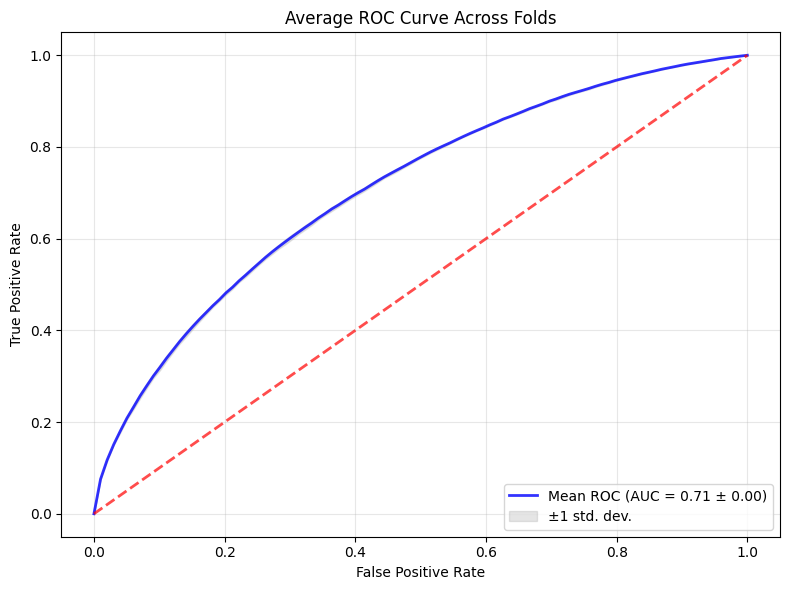

In [ ]:
# === 1. ROC Curve (Mean + Std) ===
plt.figure(figsize=(8, 6))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = {:.2f} ± {:.2f})'.format(mean_auc, std_auc),
         lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2,
                 label='±1 std. dev.')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve Across Folds')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 📉 2. Confusion Matrix (aggregated across folds)

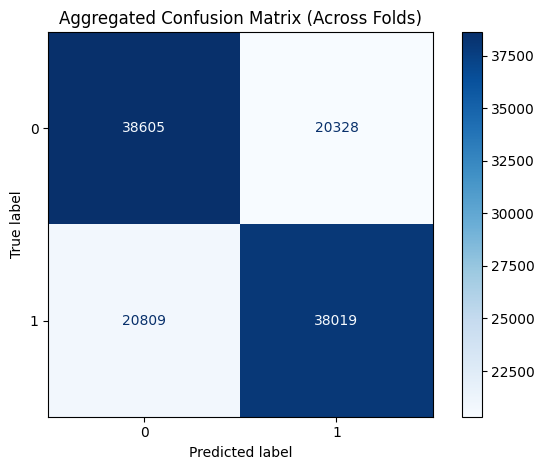

In [ ]:
# === 2. Aggregated Confusion Matrix ===
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Aggregated Confusion Matrix (Across Folds)")
plt.grid(False)
plt.tight_layout()
plt.show()

# 🌿 3. Feature Importance Plot (Gain-based)

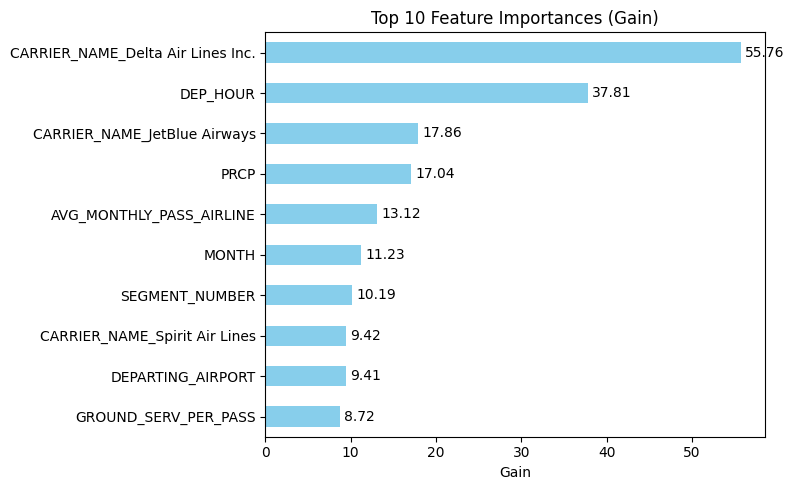

In [ ]:
# === 3. Feature Importance Plot (Gain-based) ===
imp = pd.Series(final_model_xgb.get_booster().get_score(importance_type='gain'))
imp = imp.sort_values(ascending=False).head(10).round(2)

imp[::-1].plot(kind='barh', color='skyblue', figsize=(8, 5))
plt.title("Top 10 Feature Importances (Gain)")
plt.xlabel("Gain")
for i, v in enumerate(imp[::-1]):
    plt.text(v + 0.5, i, str(v), va='center')
plt.tight_layout()
plt.show()

# ====SHAP====

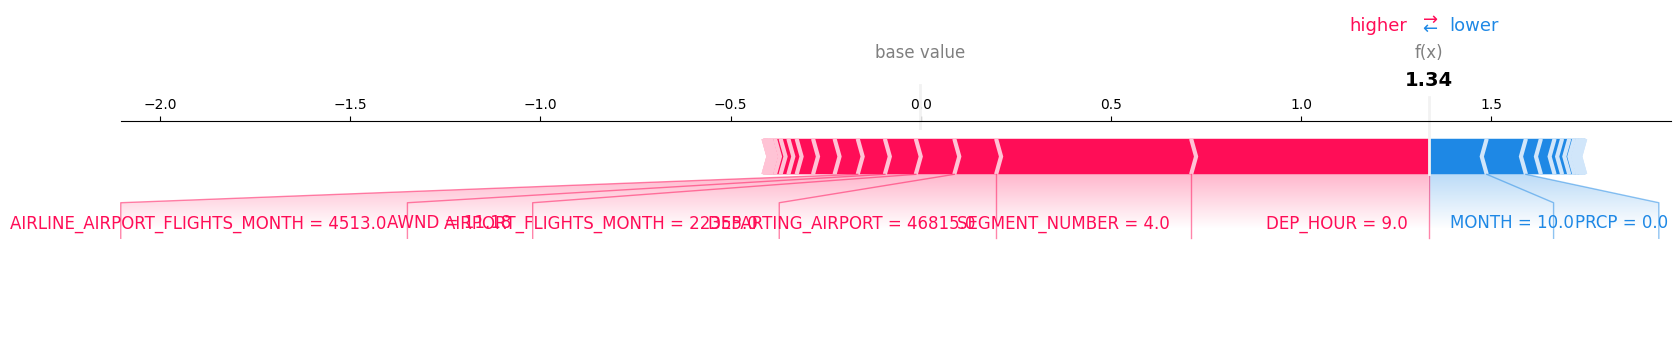

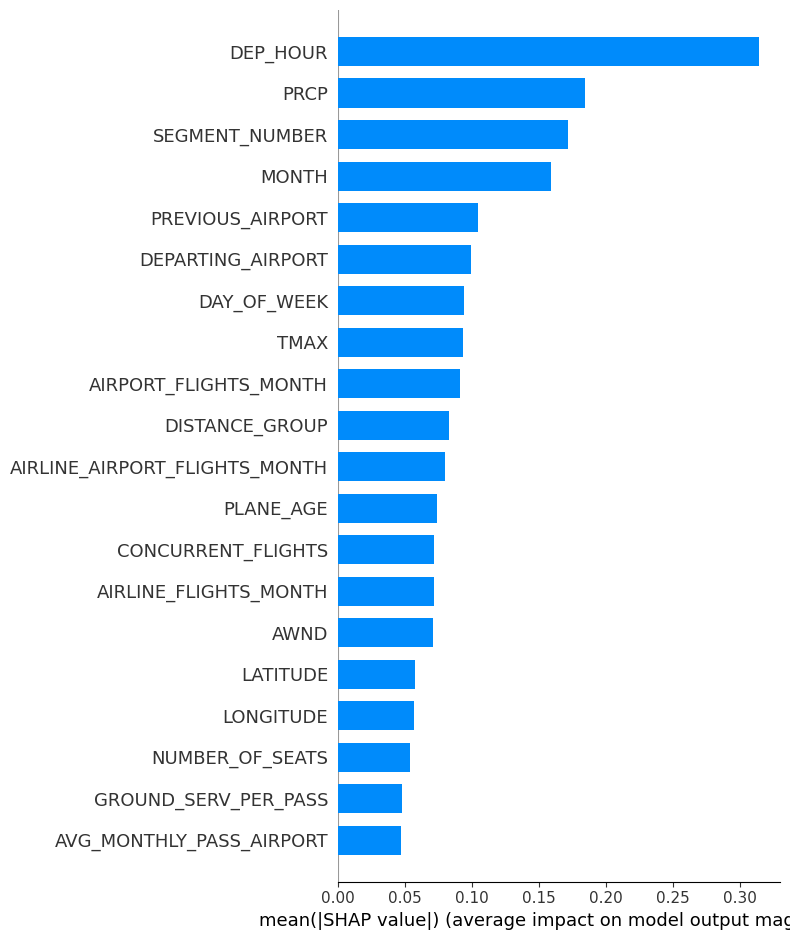

In [ ]:
# === SHAP Explanation ===
import shap

# Enable JS visualizations for notebooks
shap.initjs()

# Create SHAP explainer
# For tree-based models like XGBoost, TreeExplainer is faster and more accurate
# but since we are passing a pipeline, KernelExplainer may be more general
# If you want to bypass pipeline and pass only xgb model for TreeExplainer, extract with:
#   final_model_xgb = pipeline_xgb.named_steps['xgb']
explainer_shap = shap.TreeExplainer(pipeline_xgb.named_steps['xgb'])

# Choose instance index (same logic as before)
i = 10000 if 10000 < len(X_test) else 0
instance = X_test.iloc[i]

# Get SHAP values for the instance
# Wrap instance in DataFrame to preserve feature names
shap_values_instance = explainer_shap.shap_values(instance.to_frame().T)

# Visualize local explanation for the chosen instance
shap.force_plot(
    explainer_shap.expected_value,
    shap_values_instance,
    instance,
    matplotlib=True
)

# Optional: Summary plot for multiple samples
shap_values_all = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values_all, X_test, plot_type="bar")
